In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
import sys
sys.path.append("./../")

In [29]:
from pathlib import Path
import math
import pickle
import pprint
import time
import datetime
#
import torch
import torchvision
from torchvision import utils
import torchvision.transforms as T
import torchvision.datasets as datasets
#
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from tqdm import tqdm
from dotted_dict import DottedDict
#
from misc.plot_utils import plot_mat, imshow
from effcn.functions import max_norm_masking
from effcn.models import MnistEcnBackbone, MnistEcnDecoder, MnistEffCapsNet
from misc.utils import mkdir_directories

### Preprocessing

In [57]:
device = torch.device("cuda")
device

device(type='cuda')

In [58]:
p_experiment = "/mnt/data/experiments/EfficientCN/mnist"
p_experiment = Path(p_experiment)

p_ckpts = p_experiment / "run_2022-01-19_14-50-25"


p_data = Path("/mnt/data/datasets")
p_model = p_ckpts / "ecn_mnist_epoch_150.ckpt"
p_model.exists()

True

In [59]:
model = MnistEffCapsNet()
model.load_state_dict(torch.load(p_model))
model = model.to(device)
model.eval()

MnistEffCapsNet(
  (backbone): MnistEcnBackbone(
    (layers): Sequential(
      (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=valid)
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
      (4): ReLU(inplace=True)
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
      (7): ReLU(inplace=True)
      (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=valid)
      (10): ReLU(inplace=True)
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (primcaps): PrimaryCaps(
    (dw_conv2d): Conv2d(128, 128, kernel_size=(9, 9), stride=(1, 1), padding=valid, groups=128)
 

### Kullbach-Leiber Divergence and PCA

In [60]:
train = True
ds_train = datasets.MNIST(root=p_data, train=train, download=True, transform=T.ToTensor())

dl_train = torch.utils.data.DataLoader(ds_train, 
                                        #batch_size=len(ds_train), 
                                        batch_size=64, 
                                        shuffle=False)

In [61]:
x,y = next(iter(dl_train))

print(x.shape)
print(y.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [62]:
def affine_xtrans(img, target, range=[-5.,5.,1]):
    arange = np.arange(range[0],(range[1]+range[2]),range[2])
    x_trans = torch.zeros([len(arange),img.shape[-3],img.shape[-2],img.shape[-1]])
    l_target = torch.zeros(len(arange))

    for i, l in enumerate(arange):
        x_trans[i] = T.functional.affine(img=img, angle=0, translate=[l,0], scale=1.,shear=0)
        l_target[i] = target
    
    return x_trans, l_target

def affine_ytrans(img, target, range=[-5.,5.,1]):
    arange = np.arange(range[0],(range[1]+range[2]),range[2])
    y_trans = torch.zeros([len(arange),img.shape[-3],img.shape[-2],img.shape[-1]])
    l_target = torch.zeros(len(arange))

    for i, l in enumerate(arange):
        y_trans[i] = T.functional.affine(img=img, angle=0, translate=[0,l], scale=1.,shear=0)
        l_target[i] = target
    
    return y_trans, l_target

def affine_rot(img, target, range=[-25.,25.,1]):
    arange = np.arange(range[0],(range[1]+range[2]),range[2])
    rot = torch.zeros([len(arange),img.shape[-3],img.shape[-2],img.shape[-1]])
    l_target = torch.zeros(len(arange))

    for i, l in enumerate(arange):
        rot[i] = T.functional.affine(img=img, angle=l, translate=[0,0], scale=1.,shear=0)
        l_target[i] = target
    
    return rot, l_target
   

In [63]:
def cov_uh_trans(uh):
    """
    uh in [k,n,m]
    k -> number of transformed images
    n -> number of output classes
    m -> number of capsul values
    """

    uh_mean = uh.mean(dim=0)
    z = uh - uh_mean
    c_k = torch.einsum('...ij, ...ik -> ...jk', z,z)
    c = torch.einsum('ijk -> jk', c_k) / c_k.shape[0]

    return c

In [64]:
affine = affine_rot
pca_eig = []
kl_div = []

pbar = tqdm(dl_train, bar_format='{bar:10}{r_bar}{bar:-10b}')

#load batchwise
for x, y in pbar:
    #calculate staistical vals
    for i, img in enumerate(x):
        #generate aff transforms
        x_aff, y_aff = affine(x[i],y[i])
        
        #Generate Caps from affine Transform
        x_aff = x_aff.to(device)
        uh_aff, _ = model.forward(x_aff)

        #PCA
        #Covariance from Caps
        cov_uh = cov_uh_trans(uh_aff)
        #Eigenvals
        eig, v_eig = torch.linalg.eig(cov_uh)
        sig = eig.float() / eig.float().sum()
        #PCA eigenvalues
        pca_eig.append(sig.tolist())


        #KL-Divergence
        #Caps from valid
        uh_aff_th = uh_aff[:,y[i],:]
        #Variance over each dimension
        var_uh_aff = torch.var(uh_aff_th, dim=0)
        #Variance normalized
        nor_uh_aff = var_uh_aff / var_uh_aff.sum()
        #uniform prior
        uni_p = 1/nor_uh_aff.shape[0]
        #Kullback-Leibler-Divergenz
        kl = (nor_uh_aff * torch.log((nor_uh_aff/uni_p))).sum()
        kl_div.append(kl.tolist())


pca_mean = torch.tensor(pca_eig).mean(dim=0)
kld_mean = torch.tensor(kl_div).mean()

██████████| 938/938 [12:41<00:00,  1.23it/s]


In [65]:
print(len(kl_div))
print(kld_mean)
print(len(pca_eig))
print(pca_mean)

kl_div[0]

60000
tensor(0.5694)
60000
tensor([0.2996, 0.1587, 0.1142, 0.0877, 0.0691, 0.0553, 0.0442, 0.0347, 0.0263,
        0.0196, 0.0156, 0.0142, 0.0143, 0.0151, 0.0156, 0.0159])


0.2795495092868805

In [66]:
stats = {
    "model": [str(p_model)],
    "dataset": [str(p_data)],
    "train": [train],
    "affine": [affine.__name__],
    "pca": {
        'pca_eig': pca_eig,
        'pca_mean': pca_mean,
    },
    "kld": {
        'kld_val': kl_div,
        'kld_mean': kld_mean,
    }
}
s =  DottedDict(stats)

In [67]:
s =  DottedDict(stats)

In [68]:
#pprint.pp(s)

In [69]:
p_semcomp = Path("/mnt/data/experiments/EfficientCN/sem_comp")
p_stats = p_semcomp / 'semcomp_mnist_{tr}_{da}'.format(tr=affine.__name__, da=datetime.datetime.fromtimestamp(time.time()).strftime('%Y_%m_%d_%H_%M_%S'))

mkdir_directories([p_stats], parents=True, exist_ok=True)

In [70]:
p_stats

PosixPath('/mnt/data/experiments/EfficientCN/sem_comp/semcomp_mnist_affine_rot_2022_01_26_18_43_14')

In [71]:
file1 = open(p_stats /'stats.pkl', 'wb')
pickle.dump(stats, file1)
file1.close()


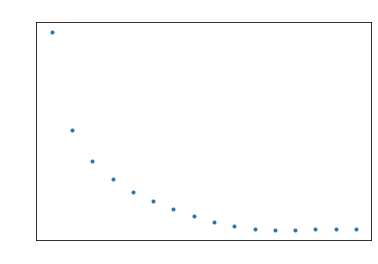

In [72]:
plt.plot(pca_mean.detach().numpy(),".")
plt.tick_params(colors="w")
plt.title(str(affine.__name__) + ", kld_mean: " + str(kld_mean.item()),color="w")

plt.savefig(p_stats /'eigenvals_mean.png')